In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# CycleGAN

CycleGAN, or Cycle-Consistent Generative Adversarial Network, is a type of neural network architecture used for image-to-image translation tasks where paired examples are not available. Developed by Jun-Yan Zhu and colleagues in 2017, CycleGAN consists of two sets of generators and discriminators that work together to transform images from one domain to another while maintaining key characteristics of the original images. It employs a cycle consistency loss, ensuring that an image translated to the target domain and then back to the original domain remains unchanged. This technique has enabled impressive applications such as turning photos into paintings, changing seasons in images, and converting animal faces to human faces, all without the need for paired training data. (ChatGPT)

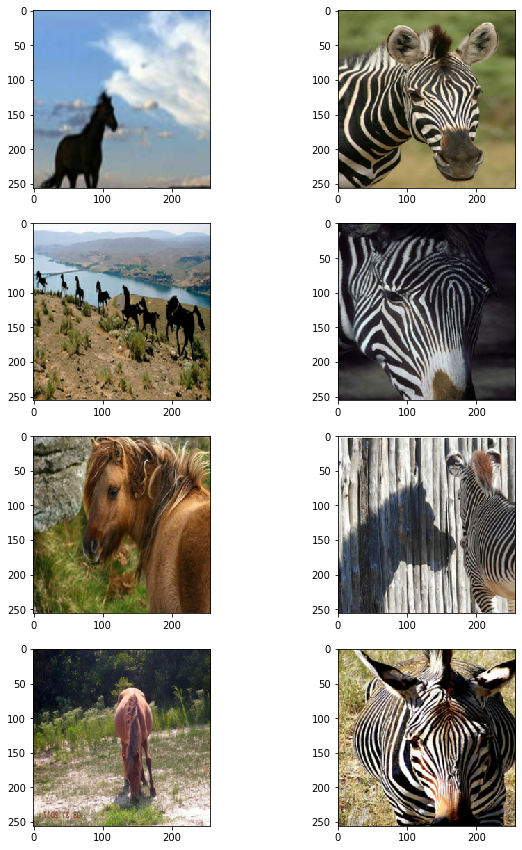

# Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image

from tqdm import tqdm
import shutil

from pathlib import Path

# Loading Data...

In [ ]:
data_root = '/kaggle/input/gan-getting-started/'
print(data_root)
print(os.listdir(data_root))
monet_path = 'monet_jpg'
photo_path = 'photo_jpg'

# Data Transform

In [ ]:
class MonetPhoto(Dataset):
    def __init__(self, data_root, monet_path, photo_path, transform=None):
        self.data_root = data_root
        self.monet_path = monet_path
        self.monet_images = os.listdir(os.path.join(data_root, monet_path))
        self.photo_path = photo_path
        self.photo_images = os.listdir(os.path.join(data_root, photo_path))
        self.transform = transform

    def __len__(self):
        return max(len(self.monet_images), len(self.photo_images))

    def __getitem__(self, idx):
        monet_image = Image.open(os.path.join(data_root, monet_path, self.monet_images[idx % len(self.monet_images)]))
        photo_image = Image.open(os.path.join(data_root, photo_path, self.photo_images[idx % len(self.photo_images)]))
        if self.transform:
            monet_image = self.transform(monet_image)
            photo_image = self.transform(photo_image)
        return monet_image, photo_image

In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

dataset = MonetPhoto(data_root, monet_path, photo_path, transform=transforms)

In [ ]:
len(dataset)

In [ ]:
x, y = dataset.__getitem__(1)
x.shape, y.shape

In [ ]:
x.max(), x.min(), y.max(), y.min()

In [ ]:
train_size, test_size = int(len(dataset) * 0.8), len(dataset) - int(len(dataset) * 0.8)

In [ ]:
training_data, testing_data = random_split(dataset, [train_size, test_size])

In [ ]:
len(training_data)

In [ ]:
train_dataloader = DataLoader(training_data.dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(testing_data.dataset, batch_size=32, shuffle=True, num_workers=2)

# EDA

In [ ]:
mones, photos = next(iter(train_dataloader))
plt.imshow(mones[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)

In [ ]:
plt.imshow(photos[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# The Model

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, device="cuda"):
        super().__init__()
        self.device = device
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect', device=self.device),
            nn.BatchNorm2d(out_channels, device=self.device),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        return self.conv(x)

# CycleGAN Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512], device="cuda"):
        super().__init__()
        self.device = device
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect', device=self.device),
            nn.LeakyReLU(0.2)
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2, device=self.device),
            )
            in_channels = feature
        
        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect', device=self.device
            )
        )
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.initial(x)
        return self.model(x)

In [ ]:
def test():
    x = (torch.randn((1,3, 256,256))).to('cuda')
    model = Discriminator().to('cuda')
    preds = model(x)
    print(preds.shape)
    
test()

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act = 'relu', use_dropout=False, device="cuda"):
        super().__init__()
        self.device = device
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect', device=self.device)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False, device=self.device),
            nn.BatchNorm2d(out_channels, device=self.device),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

# CycleGAN Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64, device="cuda"):
        super().__init__()
        self.device = device
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect', device=self.device),
            nn.LeakyReLU(0.2),
        ) #128
        
        self.down1 = Block(features, features*2, down=True, act='leaky', use_dropout=False)   #64
        self.down2 = Block(features*2, features*4, down=True, act='leaky', use_dropout=False) #32
        self.down3 = Block(features*4, features*8, down=True, act='leaky', use_dropout=False) #16
        self.down4 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #8
        self.down5 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #4
        self.down6 = Block(features*8, features*8, down=True, act='leaky', use_dropout=False) #2
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features*8, features*8, 4, 2, 1, padding_mode='reflect', device=self.device), #1x1
            nn.ReLU(),
        )
        self.up1 = Block(features*8, features*8, down=False, act='relu', use_dropout=True)
        self.up2 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up3 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=True)
        self.up4 = Block(features*8*2, features*8, down=False, act='relu', use_dropout=False)
        self.up5 = Block(features*8*2, features*4, down=False, act='relu', use_dropout=False)
        self.up6 = Block(features*4*2, features*2, down=False, act='relu', use_dropout=False)
        self.up7 = Block(features*2*2, features, down=False, act='relu', use_dropout=False)
        self.finil_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1, device=self.device),
            nn.Tanh(),
        )
        
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        
        bottleneck = self.bottleneck(d7)
        
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        
        return self.finil_up(torch.cat([up7, d1], 1))

In [ ]:
def test():
    x = torch.randn((1,3, 256,256)).to('cuda')
    model = Generator()
    preds = model(x)
    print(preds.shape)
    
test()

# Training

In [ ]:
class Trainer:
    def __init__(
        self,
        train_data: DataLoader,
        val_data: DataLoader,
        generator: torch.nn.Module,
        discriminator: torch.nn.Module,
        nb_epochs: int = 5,
        device: str = "cuda",
        save_path: str = None,
    ):
        self.train_data = train_data
        self.val_data = val_data
        self.generator = generator
        self.discriminator = discriminator
        self.nb_epochs = nb_epochs
        self.device = device
        self.save_path = Path(save_path) if save_path else save_path

        self.z = next(iter(self.val_data))[0][:32].to(self.device)
        
        self.logs = {
            "Step": [],
            "Train_g_loss": [],
            "Train_d_loss": [],
            "Val_g_loss": [],
            "Val_d_loss": [],
            "Samples": [],
        }

    def init_optimizers(self, lr: float=3e-4, betas: tuple=(0.5, 0.999)):
        self.g_optimizer = torch.optim.Adam(
            self.generator.parameters(), lr=lr, betas=betas
        )
        self.d_optimizer = torch.optim.Adam(
            self.discriminator.parameters(), lr=lr, betas=betas
        )

    def train(self):
        assert (self.g_optimizer is not None) and (
            self.d_optimizer is not None
        ), "Please run Trainer().init_optimizer()"

        # Loading best model
        if self.save_path and self.save_path.exists():
            self.load_model()
            
        best_score = torch.inf

        for i in range(self.nb_epochs):
            train_d_loss, train_g_loss, val_d_loss, val_g_loss = 0, 0, 0, 0
            self.generator.train()
            self.discriminator.train()
            # Train loop
            loop = tqdm(
                enumerate(self.train_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} train",
                leave=False,
                total=len(self.train_data),
            )
            for step, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                # Train step
                g_loss, d_loss = self.train_step(x, y)

                train_g_loss += g_loss
                train_d_loss += d_loss

                loop.set_postfix_str(
                    f"g_loss: {train_g_loss / (step + 1) :.2f}, d_loss: {train_d_loss / (step + 1) :.2f}"
                )

            # Validation loop
            self.generator.eval()
            self.discriminator.eval()

            loop = tqdm(
                enumerate(self.val_data),
                desc=f"Epoch {i + 1}/{self.nb_epochs} validation",
                leave=True,
                total=len(self.val_data),
            )
            for step, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                # Validation step
                g_loss, d_loss = self.val_step(x, y)

                val_g_loss += g_loss
                val_d_loss += d_loss

                loop.set_postfix_str(
                    f"g_loss: {val_g_loss / (step + 1) :.2f} d_loss: {val_d_loss / (step + 1) :.2f}"
                )

            # Saving best model
            if self.save_path and best_score > val_g_loss:
                best_score = val_g_loss
                self.save_model()

            # Log
            self.log_metrics(
                step=i,
                train_g_loss=train_g_loss,
                train_d_loss=train_d_loss,
                val_g_loss=val_g_loss,
                val_d_loss=val_d_loss,
            )
            # plot
            fake_img = self.generator((photos[0].unsqueeze(0)).to('cuda'))
            fake_img = fake_img[0].cpu().detach()
            
            fig, ax = plt.subplots(1, 2, figsize=(20, 4))
            ax[0].imshow(photos[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)
            ax[0].set_title("Photo")
            ax[0].set(xticks=[], yticks=[])
            ax[1].imshow(fake_img.permute(1, 2, 0).numpy() * 0.5 + 0.5  )
            ax[1].set_title("FakeMonet")
            ax[1].set(xticks=[], yticks=[])
            plt.show()
            
        return self.logs

    def train_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor
    ) -> tuple:
        self.g_optimizer.zero_grad(set_to_none=True)
        self.d_optimizer.zero_grad(set_to_none=True)
        
        fake_ = self.discriminator(
            self.generator(x)
        )
        real = self.discriminator(y)
        d_loss = (
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=self.device)) + 
            torch.nn.functional.mse_loss(fake_, torch.zeros_like(fake_, device=self.device))
        )

        d_loss.backward()
        self.d_optimizer.step()
        
        fake = self.discriminator(
            self.generator(x)
        )
        
        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=self.device))
        g_loss.backward()
        self.g_optimizer.step()

        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def val_step(
        self,
        x: torch.Tensor,
        y: torch.Tensor,
    ) -> tuple:
        fake = self.discriminator(
            self.generator(x)
        )
        real = self.discriminator(y)
        g_loss = torch.nn.functional.mse_loss(fake, torch.ones_like(fake, device=self.device))
        d_loss = (
            torch.nn.functional.mse_loss(real, torch.ones_like(real, device=self.device)) + 
            torch.nn.functional.mse_loss(fake, torch.zeros_like(fake, device=self.device))
        )
        return g_loss.item(), d_loss.item()

    @torch.no_grad()
    def log_metrics(
        self,
        step: int,
        train_g_loss: torch.Tensor,
        train_d_loss: torch.Tensor,
        val_g_loss: torch.Tensor,
        val_d_loss: torch.Tensor,
    ):
        self.logs["Step"].append(step)
        self.logs["Train_g_loss"].append(train_g_loss / len(self.train_data))
        self.logs["Train_d_loss"].append(train_d_loss / len(self.train_data))
        self.logs["Val_g_loss"].append(val_g_loss / len(self.val_data))
        self.logs["Val_d_loss"].append(val_d_loss / len(self.val_data))
        self.logs["Samples"].append(make_grid(self.generator(self.z).cpu() * 0.5 + 0.5, normalize=True))

    def save_model(self, full: bool = False):
        if full:
            torch.save(self.generator, Path(self.save_path) / "generator.pth")
            torch.save(self.discriminator, Path(self.save_path) / "discriminator.pth")
        else:
            torch.save(
                self.generator.state_dict(),
                Path(self.save_path) / "generator_weights.pth",
            )
            torch.save(
                self.discriminator.state_dict(),
                Path(self.save_path) / "discriminator_weights.pth",
            )

    def load_model(self, full: bool = False):
        if (
            full
            and (self.save_path / "generator.pth").is_file()
            and (self.save_path / "discriminator.pth").is_file()
        ):
            self.generator = torch.load(self.save_path / "generator.pth")
            self.discriminator = torch.load(self.save_path / "discriminator.pth")
        elif (
            self.save_path / "generator_weights.pth"
        ).is_file() and (
            self.save_path / "discriminator_weights.pth"
        ).is_file():
            self.generator.load_state_dict(torch.load(self.save_path / "generator_weights.pth"))
            self.discriminator.load_state_dict(torch.load(self.save_path / "discriminator_weights.pth"))

In [ ]:
!mkdir models

In [ ]:
trainer = Trainer(
        train_data = train_dataloader,
        val_data = test_dataloader,
        generator = Generator(in_channels=3, features=64),
        discriminator = Discriminator(),
        nb_epochs = 30,
        device = device,
        save_path = './models/'
    )

In [ ]:
trainer.load_model()

# Let's see those photos

In [ ]:
trainer.init_optimizers()
logs = trainer.train()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))
ax[0].plot(logs["Step"], logs["Train_g_loss"], label="Train_g_loss")
ax[1].plot(logs["Step"], logs["Train_d_loss"], label="Train_d_loss")
ax[0].plot(logs["Step"], logs["Val_g_loss"], label="Val_g_loss")
ax[1].plot(logs["Step"], logs["Val_d_loss"], label="Val_d_loss")
ax[0].set_title("Generator loss")
ax[1].set_title("Discriminator loss")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
plt.imshow(photos[1].permute(1, 2, 0).numpy() * 0.5 + 0.5)

In [ ]:
fake_img = trainer.generator((photos[1].unsqueeze(0)).to('cuda'))
fake_img = fake_img[0].cpu().detach()
plt.imshow(fake_img.permute(1, 2, 0).numpy() * 0.5 + 0.5  )

# Submission

In [ ]:
! mkdir ../images

In [ ]:
with torch.no_grad():
    for i, (_,img) in enumerate(DataLoader(dataset, batch_size=1, shuffle=False)):
        prediction = trainer.generator(img.to(device))[0].cpu().permute(1, 2, 0).numpy()* 0.5 + 0.5
        im = Image.fromarray((prediction * 255).astype(np.uint8))
        im.save("../images/" + str(i) + ".jpg")

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")